# 4. 회귀 분석 (Regression Analysis)

## 목표
1. CV와 주요 성적 지표의 관계 분석
2. CV를 통한 타율 예측 모델 구축
3. 일관성과 성적의 트레이드오프 관계 규명

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

nanum_candidates = [
    '/Users/hoyana/Library/Fonts/NanumGothic-Regular.ttf',
    '/Users/hoyana/Library/Fonts/NanumGothic-Bold.ttf',
    '/Users/hoyana/Library/Fonts/NanumGothic-ExtraBold.ttf',
    '/Library/Fonts/NanumGothic-Regular.ttf',
    '/Library/Fonts/NanumGothic-Bold.ttf',
    '/Library/Fonts/NanumGothic-ExtraBold.ttf',
]
for path in nanum_candidates:
    if Path(path).exists():
        fm.fontManager.addfont(path)

plt.rcParams['font.family'] = ['NanumGothic', 'AppleGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


## 4.1 데이터 로드

In [2]:
data_path = '../outputs/'
df = pd.read_csv(data_path + 'eda_data.csv')

print(f"데이터 Shape: {df.shape}")
df.head()

데이터 Shape: (903, 43)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,age,position_group,career_years,career_group,HR_per_AB,batter_type,CV,std_daily_avg,games_count,consistency_level
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,34.0,내야수,1,5년차 이하,0.043716,장타형,0.892193,0.280743,50,안정
1,1,강경학,2015,한화,0.257,120,311,50,80,7,...,24.0,내야수,8,6년차 이상,0.006431,안타형,1.175115,0.272672,103,불안정
2,1,강경학,2016,한화,0.158,46,101,16,16,3,...,25.0,내야수,8,6년차 이상,0.009901,안타형,1.426298,0.194028,37,매우 불안정
3,1,강경학,2018,한화,0.278,77,245,42,68,11,...,27.0,내야수,8,6년차 이상,0.020408,안타형,1.056978,0.271967,73,불안정
4,4,강민호,2005,롯데,0.243,104,214,20,52,11,...,21.0,포수,15,6년차 이상,0.009346,안타형,1.378389,0.288523,93,매우 불안정


## 4.2 상관 분석

In [3]:
from scipy.stats import spearmanr

print("=== CV와 주요 변수의 Spearman 상관계수 ===")
variables = ['avg', 'OPS', 'SLG', 'OBP', 'HR', 'RBI', 'H', 'AB']

for var in variables:
    corr, p_value = spearmanr(df['CV'], df[var])
    print(f"CV vs {var:>6s}: 상관계수={corr:>7.4f}, p-value={p_value:.4f}")

=== CV와 주요 변수의 Spearman 상관계수 ===
CV vs    avg: 상관계수=-0.7948, p-value=0.0000
CV vs    OPS: 상관계수=-0.7126, p-value=0.0000
CV vs    SLG: 상관계수=-0.6411, p-value=0.0000
CV vs    OBP: 상관계수=-0.7147, p-value=0.0000
CV vs     HR: 상관계수=-0.5632, p-value=0.0000
CV vs    RBI: 상관계수=-0.7647, p-value=0.0000
CV vs      H: 상관계수=-0.8825, p-value=0.0000
CV vs     AB: 상관계수=-0.8194, p-value=0.0000


## 4.3 단순 선형 회귀: CV → 타율

In [4]:
X = df[['CV']].values
y = df['avg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

y_pred_train = model_simple.predict(X_train)
y_pred_test = model_simple.predict(X_test)

print("=== 단순 선형 회귀: CV → 타율 ===")
print(f"회귀식: 타율 = {model_simple.intercept_:.4f} + ({model_simple.coef_[0]:.4f}) × CV")
print(f"\nTrain R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

=== 단순 선형 회귀: CV → 타율 ===
회귀식: 타율 = 0.4252 + (-0.1390) × CV

Train R²: 0.6382
Test R²: 0.6595
Test RMSE: 0.0241
Test MAE: 0.0187


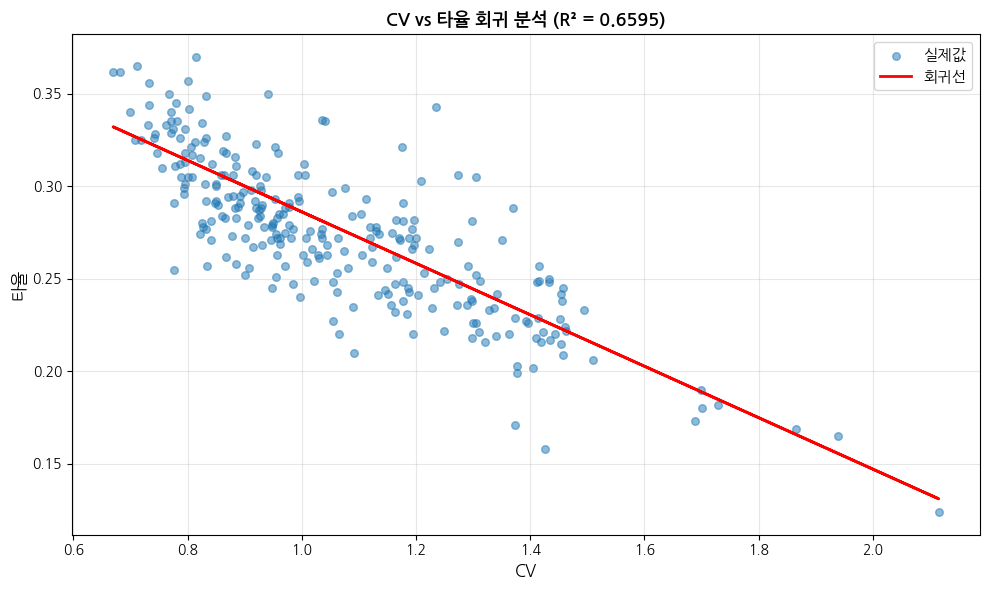

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.5, s=30, label='실제값')
plt.plot(X_test, y_pred_test, 'r-', linewidth=2, label='회귀선')
plt.xlabel('CV', fontsize=12)
plt.ylabel('타율', fontsize=12)
plt.title(f'CV vs 타율 회귀 분석 (R² = {r2_score(y_test, y_pred_test):.4f})', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(data_path + 'regression_cv_avg.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.4 다중 선형 회귀: CV + 기타 변수 → 타율

In [6]:
features = ['CV', 'HR', 'AB', 'age', 'BMI']
df_clean = df[features + ['avg']].dropna()

X_multi = df_clean[features].values
y_multi = df_clean['avg'].values

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_m)
X_test_scaled = scaler.transform(X_test_m)

model_multi = LinearRegression()
model_multi.fit(X_train_scaled, y_train_m)

y_pred_train_m = model_multi.predict(X_train_scaled)
y_pred_test_m = model_multi.predict(X_test_scaled)

print("=== 다중 선형 회귀: CV + 기타 변수 → 타율 ===")
print(f"절편: {model_multi.intercept_:.4f}")
print("\n회귀 계수:")
for feat, coef in zip(features, model_multi.coef_):
    print(f"  {feat:>6s}: {coef:>8.4f}")

print(f"\nTrain R²: {r2_score(y_train_m, y_pred_train_m):.4f}")
print(f"Test R²: {r2_score(y_test_m, y_pred_test_m):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_m, y_pred_test_m)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test_m, y_pred_test_m):.4f}")

=== 다중 선형 회귀: CV + 기타 변수 → 타율 ===
절편: 0.2786

회귀 계수:
      CV:  -0.0372
      HR:   0.0038
      AB:  -0.0109
     age:   0.0028
     BMI:  -0.0014

Train R²: 0.6697
Test R²: 0.6736
Test RMSE: 0.0236
Test MAE: 0.0177


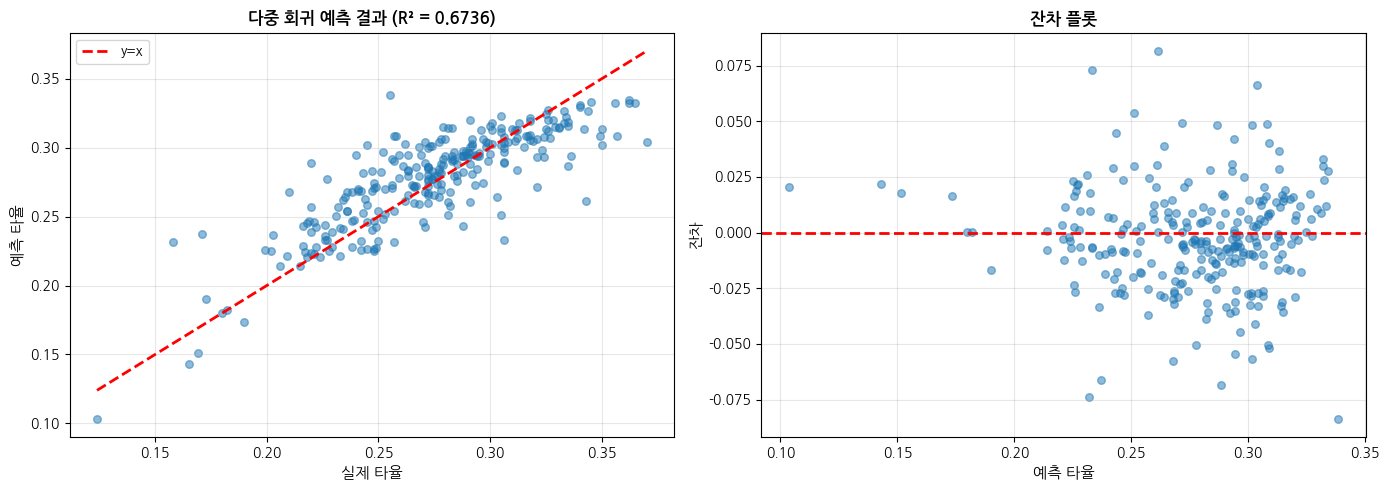

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_m, y_pred_test_m, alpha=0.5, s=30)
axes[0].plot([y_test_m.min(), y_test_m.max()], [y_test_m.min(), y_test_m.max()], 
             'r--', linewidth=2, label='y=x')
axes[0].set_xlabel('실제 타율', fontsize=11)
axes[0].set_ylabel('예측 타율', fontsize=11)
axes[0].set_title(f'다중 회귀 예측 결과 (R² = {r2_score(y_test_m, y_pred_test_m):.4f})', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test_m - y_pred_test_m
axes[1].scatter(y_pred_test_m, residuals, alpha=0.5, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('예측 타율', fontsize=11)
axes[1].set_ylabel('잔차', fontsize=11)
axes[1].set_title('잔차 플롯', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_path + 'regression_multi_avg.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.5 회귀 분석: CV → OPS

In [8]:
X_ops = df[['CV']].values
y_ops = df['OPS'].values

X_train_ops, X_test_ops, y_train_ops, y_test_ops = train_test_split(
    X_ops, y_ops, test_size=0.3, random_state=42
)

model_ops = LinearRegression()
model_ops.fit(X_train_ops, y_train_ops)

y_pred_train_ops = model_ops.predict(X_train_ops)
y_pred_test_ops = model_ops.predict(X_test_ops)

print("=== 단순 선형 회귀: CV → OPS ===")
print(f"회귀식: OPS = {model_ops.intercept_:.4f} + ({model_ops.coef_[0]:.4f}) × CV")
print(f"\nTrain R²: {r2_score(y_train_ops, y_pred_train_ops):.4f}")
print(f"Test R²: {r2_score(y_test_ops, y_pred_test_ops):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_ops, y_pred_test_ops)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test_ops, y_pred_test_ops):.4f}")

=== 단순 선형 회귀: CV → OPS ===
회귀식: OPS = 1.1851 + (-0.3946) × CV

Train R²: 0.4999
Test R²: 0.5237
Test RMSE: 0.0888
Test MAE: 0.0708


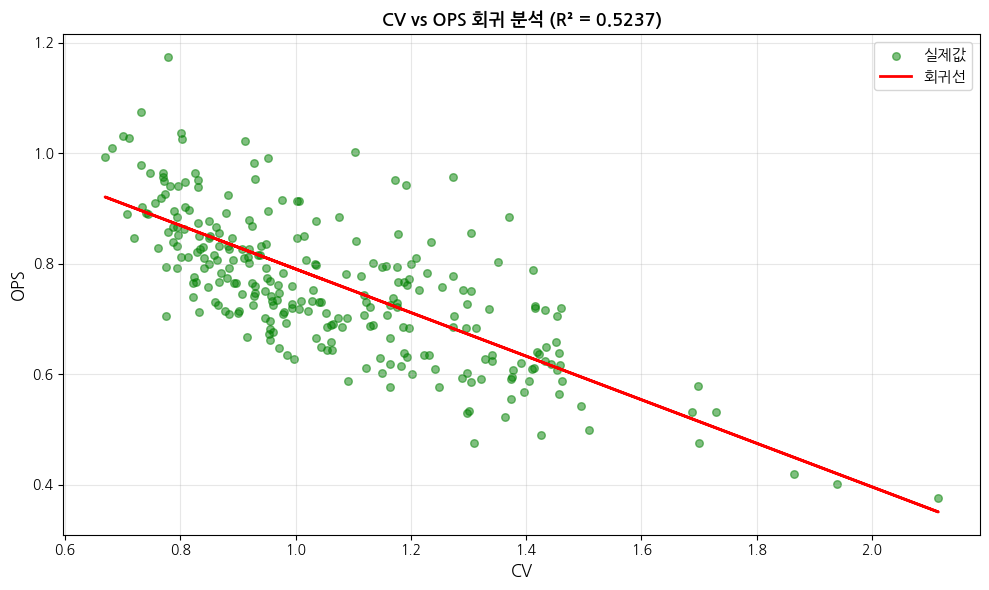

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test_ops, y_test_ops, alpha=0.5, s=30, label='실제값', color='green')
plt.plot(X_test_ops, y_pred_test_ops, 'r-', linewidth=2, label='회귀선')
plt.xlabel('CV', fontsize=12)
plt.ylabel('OPS', fontsize=12)
plt.title(f'CV vs OPS 회귀 분석 (R² = {r2_score(y_test_ops, y_pred_test_ops):.4f})', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(data_path + 'regression_cv_ops.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.6 다중 회귀: 일관성과 성적의 복합 모델

In [10]:
features_ops = ['CV', 'HR', 'H', 'BB', 'AB', 'age']
df_clean_ops = df[features_ops + ['OPS']].dropna()

X_multi_ops = df_clean_ops[features_ops].values
y_multi_ops = df_clean_ops['OPS'].values

X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(
    X_multi_ops, y_multi_ops, test_size=0.3, random_state=42
)

scaler_ops = StandardScaler()
X_train_scaled_ops = scaler_ops.fit_transform(X_train_mo)
X_test_scaled_ops = scaler_ops.transform(X_test_mo)

model_multi_ops = LinearRegression()
model_multi_ops.fit(X_train_scaled_ops, y_train_mo)

y_pred_train_mo = model_multi_ops.predict(X_train_scaled_ops)
y_pred_test_mo = model_multi_ops.predict(X_test_scaled_ops)

print("=== 다중 선형 회귀: 복합 변수 → OPS ===")
print(f"절편: {model_multi_ops.intercept_:.4f}")
print("\n회귀 계수 (표준화):")
for feat, coef in zip(features_ops, model_multi_ops.coef_):
    print(f"  {feat:>6s}: {coef:>8.4f}")

print(f"\nTrain R²: {r2_score(y_train_mo, y_pred_train_mo):.4f}")
print(f"Test R²: {r2_score(y_test_mo, y_pred_test_mo):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_mo, y_pred_test_mo)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test_mo, y_pred_test_mo):.4f}")

=== 다중 선형 회귀: 복합 변수 → OPS ===
절편: 0.7692

회귀 계수 (표준화):
      CV:  -0.0464
      HR:   0.0681
       H:   0.1738
      BB:   0.0279
      AB:  -0.1999
     age:  -0.0013

Train R²: 0.8970
Test R²: 0.8818
Test RMSE: 0.0442
Test MAE: 0.0317


## 4.7 변수 중요도 시각화

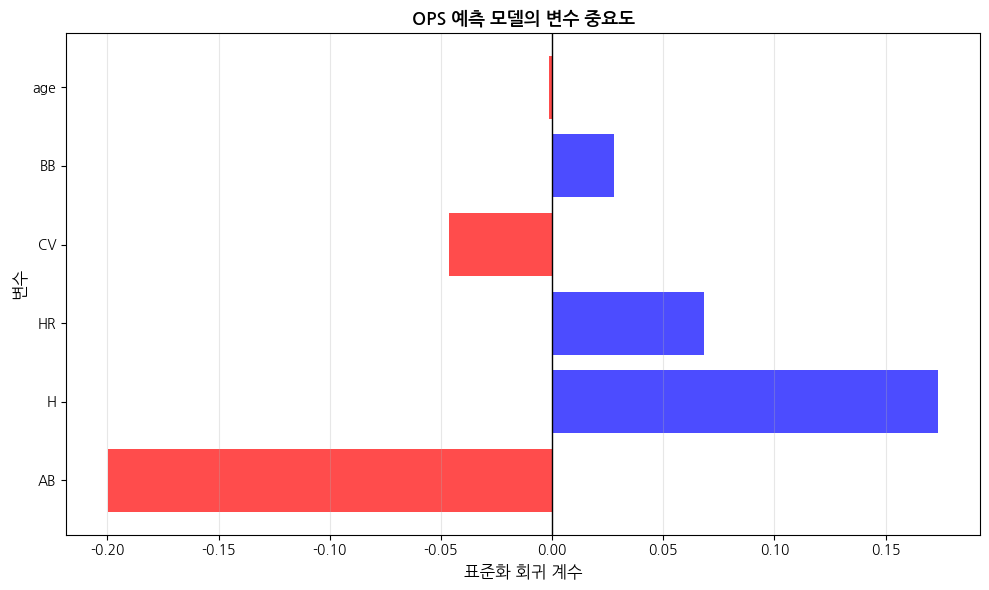


=== 변수 중요도 (절대값 기준) ===
    변수        계수       절대값
4   AB -0.199886  0.199886
2    H  0.173771  0.173771
1   HR  0.068130  0.068130
0   CV -0.046412  0.046412
3   BB  0.027919  0.027919
5  age -0.001259  0.001259


In [11]:
coef_df = pd.DataFrame({
    '변수': features_ops,
    '계수': model_multi_ops.coef_,
    '절대값': np.abs(model_multi_ops.coef_)
}).sort_values('절대값', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in coef_df['계수']]
plt.barh(coef_df['변수'], coef_df['계수'], color=colors, alpha=0.7)
plt.xlabel('표준화 회귀 계수', fontsize=12)
plt.ylabel('변수', fontsize=12)
plt.title('OPS 예측 모델의 변수 중요도', fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(data_path + 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== 변수 중요도 (절대값 기준) ===")
print(coef_df[['변수', '계수', '절대값']])

## 4.8 모델 성능 비교

In [12]:
results = pd.DataFrame({
    '모델': [
        'CV → 타율 (단순)',
        'CV + 변수 → 타율 (다중)',
        'CV → OPS (단순)',
        'CV + 변수 → OPS (다중)'
    ],
    'Train R²': [
        r2_score(y_train, y_pred_train),
        r2_score(y_train_m, y_pred_train_m),
        r2_score(y_train_ops, y_pred_train_ops),
        r2_score(y_train_mo, y_pred_train_mo)
    ],
    'Test R²': [
        r2_score(y_test, y_pred_test),
        r2_score(y_test_m, y_pred_test_m),
        r2_score(y_test_ops, y_pred_test_ops),
        r2_score(y_test_mo, y_pred_test_mo)
    ],
    'Test RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_test)),
        np.sqrt(mean_squared_error(y_test_m, y_pred_test_m)),
        np.sqrt(mean_squared_error(y_test_ops, y_pred_test_ops)),
        np.sqrt(mean_squared_error(y_test_mo, y_pred_test_mo))
    ]
})

print("\n=== 모델 성능 비교 ===")
print(results.to_string(index=False))


=== 모델 성능 비교 ===
                모델  Train R²  Test R²  Test RMSE
      CV → 타율 (단순)  0.638212 0.659465   0.024120
 CV + 변수 → 타율 (다중)  0.669666 0.673640   0.023613
     CV → OPS (단순)  0.499860 0.523745   0.088779
CV + 변수 → OPS (다중)  0.896952 0.881777   0.044233


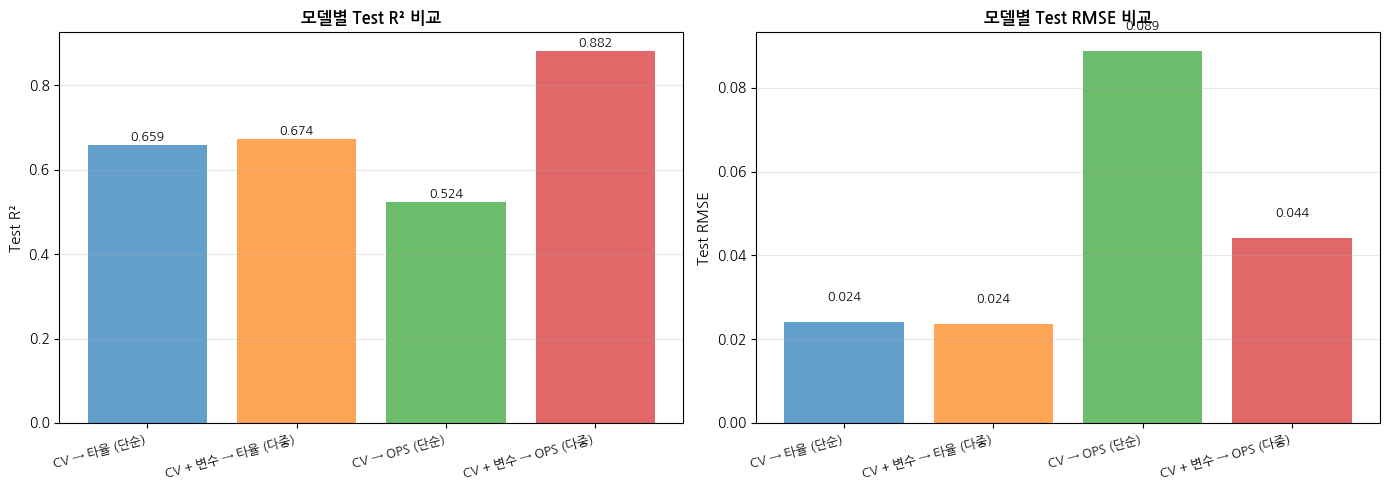

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = range(len(results))
axes[0].bar(x, results['Test R²'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
axes[0].set_xticks(x)
axes[0].set_xticklabels(results['모델'], rotation=15, ha='right', fontsize=9)
axes[0].set_ylabel('Test R²', fontsize=11)
axes[0].set_title('모델별 Test R² 비교', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(results['Test R²']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

axes[1].bar(x, results['Test RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(results['모델'], rotation=15, ha='right', fontsize=9)
axes[1].set_ylabel('Test RMSE', fontsize=11)
axes[1].set_title('모델별 Test RMSE 비교', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(results['Test RMSE']):
    axes[1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(data_path + 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.9 결과 요약

In [14]:
print("\n" + "="*70)
print("회귀 분석 종합 결과".center(70))
print("="*70)

print("\n[주요 발견사항]")
print("1. CV와 타율의 관계:")
print(f"   - 단순 회귀 R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"   - CV는 타율에 대해 {'음의' if model_simple.coef_[0] < 0 else '양의'} 관계")

print("\n2. CV와 OPS의 관계:")
print(f"   - 단순 회귀 R²: {r2_score(y_test_ops, y_pred_test_ops):.4f}")
print(f"   - CV는 OPS에 대해 {'음의' if model_ops.coef_[0] < 0 else '양의'} 관계")

print("\n3. 다중 회귀 모델 성능:")
print(f"   - 타율 예측 R²: {r2_score(y_test_m, y_pred_test_m):.4f}")
print(f"   - OPS 예측 R²: {r2_score(y_test_mo, y_pred_test_mo):.4f}")

print("\n4. 가장 중요한 예측 변수 (OPS 기준):")
top_3 = coef_df.head(3)
for idx, row in top_3.iterrows():
    print(f"   - {row['변수']}: {row['계수']:.4f}")

print("\n" + "="*70)


                             회귀 분석 종합 결과                              

[주요 발견사항]
1. CV와 타율의 관계:
   - 단순 회귀 R²: 0.6595
   - CV는 타율에 대해 음의 관계

2. CV와 OPS의 관계:
   - 단순 회귀 R²: 0.5237
   - CV는 OPS에 대해 음의 관계

3. 다중 회귀 모델 성능:
   - 타율 예측 R²: 0.6736
   - OPS 예측 R²: 0.8818

4. 가장 중요한 예측 변수 (OPS 기준):
   - AB: -0.1999
   - H: 0.1738
   - HR: 0.0681

